In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read parquet
df_occ_full = pd.read_parquet("occupancy_new_metric.parquet")

In [2]:
# We have a week's worth of data
df_occ_full["date_daily"].unique()

<DatetimeArray>
['2023-03-05 00:00:00', '2023-03-06 00:00:00', '2023-03-07 00:00:00',
 '2023-03-08 00:00:00', '2023-03-09 00:00:00', '2023-03-10 00:00:00',
 '2023-03-11 00:00:00']
Length: 7, dtype: datetime64[ns]

In [3]:
# Work with weeks days only to capture real trends
week_ends = pd.to_datetime(["2023-03-05", "2023-03-11"])
df_occ = df_occ_full[~df_occ_full["date_daily"].isin(week_ends)].copy() # Removes weekends
df_occ["date_daily"].unique()

<DatetimeArray>
['2023-03-06 00:00:00', '2023-03-07 00:00:00', '2023-03-08 00:00:00',
 '2023-03-09 00:00:00', '2023-03-10 00:00:00']
Length: 5, dtype: datetime64[ns]

In [4]:
# Max Occupation for each day per space
max_occ_time = df_occ.loc[df_occ.groupby(["building_name","space_name","date_daily"])["avg_occ"].idxmax(), 
       ["building_name","space_name","date_time","avg_occ"]].reset_index(drop=True)
max_occ_time

building_name         space_name           date_time  avg_occ
0      Building_1  Space1_Building_1 2023-03-06 09:00:00      131
1      Building_1  Space1_Building_1 2023-03-07 09:00:00      323
2      Building_1  Space1_Building_1 2023-03-08 09:00:00      225
3      Building_1  Space1_Building_1 2023-03-09 09:00:00      249
4      Building_1  Space1_Building_1 2023-03-10 08:00:00       56
..            ...                ...                 ...      ...
310    Building_9  Space2_Building_9 2023-03-06 00:00:00        0
311    Building_9  Space2_Building_9 2023-03-07 00:00:00        0
312    Building_9  Space2_Building_9 2023-03-08 00:00:00        0
313    Building_9  Space2_Building_9 2023-03-09 00:00:00        0
314    Building_9  Space2_Building_9 2023-03-10 00:00:00        0

[315 rows x 4 columns]

In [5]:
# Extracting time of day of max occupation for each space
new_df_max_times = max_occ_time.copy()
new_df_max_times["hour_of_max_occupation"] = new_df_max_times["date_time"].dt.hour
mean_max_times = new_df_max_times.groupby(["building_name","space_name"])["hour_of_max_occupation"].mean()
time_of_max_occ = np.array(mean_max_times)
min_index = time_of_max_occ.argmin()
space = df_occ["space_name"].unique()[min_index]
print(space)

Space2_Building_9


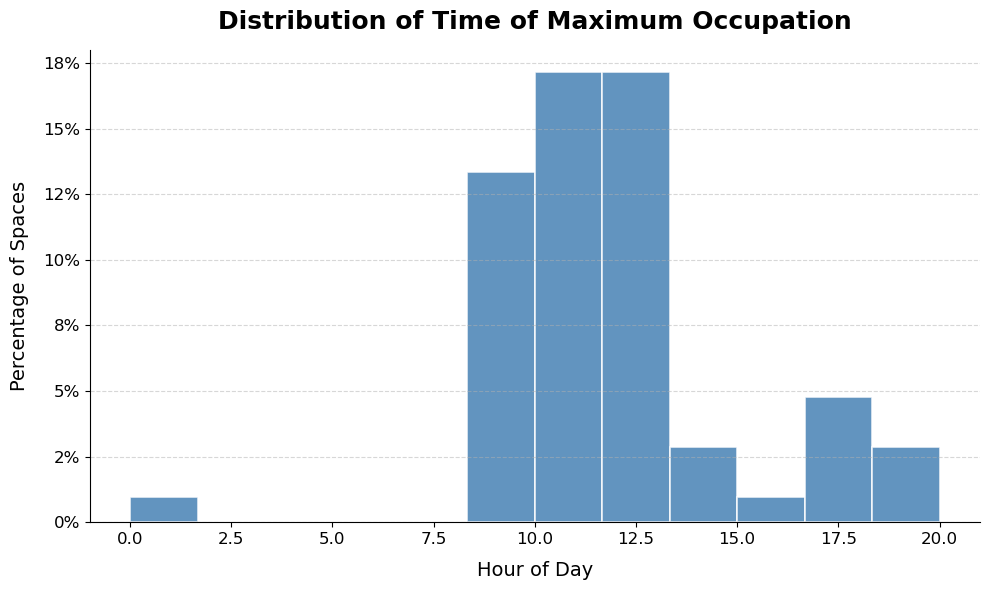

In [6]:
plt.figure(figsize=(10,6))

# Histogram normalized to percentages
plt.hist(
    time_of_max_occ,
    bins=12,                     # adjust bins to match your data resolution
    density=True,
    color="steelblue",
    edgecolor="white",
    linewidth=1.2,
    alpha=0.85
)

# Format y-axis as percentages
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x*100:.0f}%")

# Titles & labels
plt.title("Distribution of Time of Maximum Occupation", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Hour of Day", fontsize=14, labelpad=10)
plt.ylabel("Percentage of Spaces", fontsize=14, labelpad=10)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Clean look
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

Mostly around early morning and mid-day. Makes sense. We see there is a bump in the middle of night. Strange. Could look into spaces after work hours, but not needed for current assignment.

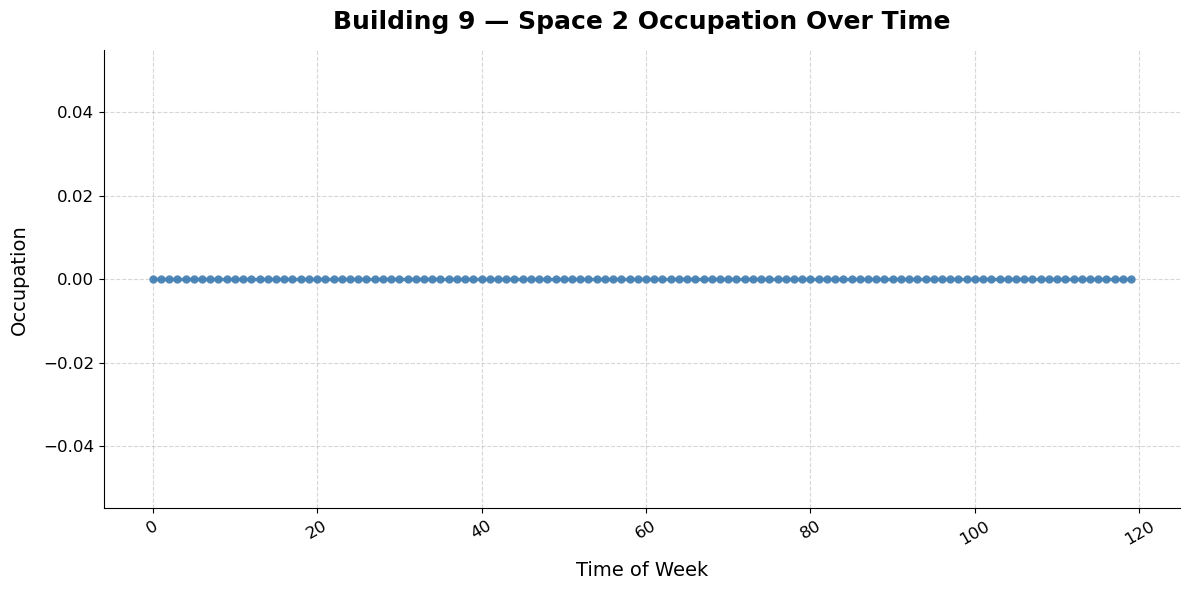

In [7]:
# Time series of Building Space 2 Building 9 

df_9 = df_occ[df_occ["space_name"]== space].reset_index(drop=True)
x = np.arange(df_9["avg_occ"].size)
y = (df_9["avg_occ"])
plt.figure(figsize=(12,6))

# Line plot with markers for clarity
plt.plot(x, y, color="steelblue", linewidth=2.5, marker="o", markersize=5, alpha=0.9)

# Titles & labels
plt.title("Building 9 — Space 2 Occupation Over Time", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Time of Week", fontsize=14, labelpad=10)
plt.ylabel("Occupation", fontsize=14, labelpad=10)

# Grid for readability
plt.grid(True, linestyle="--", alpha=0.5)

# Axis ticks
plt.xticks(fontsize=12, rotation=30)   # rotate if time labels overlap
plt.yticks(fontsize=12)

# Remove unnecessary spines for clean look
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

This space was not used all week...

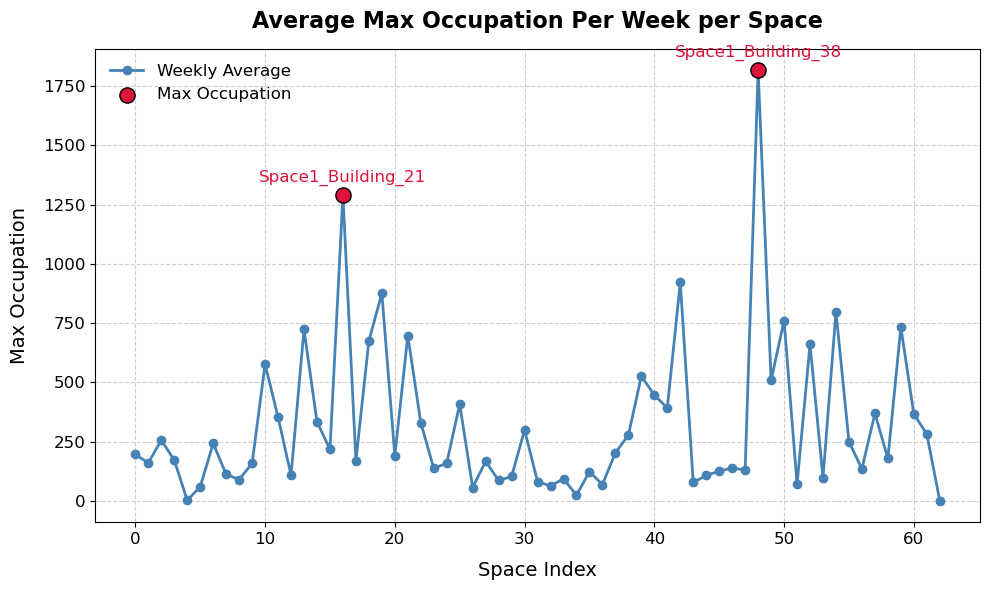

Spaces with max occupation: ['Space1_Building_21' 'Space1_Building_38']


In [8]:
# Averageing max occ for the week
avg_occ_week = max_occ_time.groupby(["building_name","space_name"])["avg_occ"].mean()
avg_occ_week = np.array(avg_occ_week).astype(int)
x = np.arange(avg_occ_week.size)
# Basic line plot
plt.figure(figsize=(10,6))
plt.plot(x, avg_occ_week, "-o", color="steelblue", linewidth=2, markersize=6, label="Weekly Average")

# Highlight max points
max_indices = [16, 48]
plt.scatter(
    [x[i] for i in max_indices],
    [avg_occ_week[i] for i in max_indices],
    color="crimson", s=120, zorder=5, edgecolors="black", label="Max Occupation"
)

# Titles and labels (clean, dashboard style)
plt.title("Average Max Occupation Per Week per Space", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Space Index", fontsize=14, labelpad=10)
plt.ylabel("Max Occupation", fontsize=14, labelpad=10)

# Grid and style
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate max points with names
space_names = max_occ_time["space_name"].unique()
for i in max_indices:
    plt.annotate(
        space_names[i],
        (x[i], avg_occ_week[i]),
        textcoords="offset points",
        xytext=(0,10),
        ha="center",
        fontsize=12,
        fontweight="medium",
        color="crimson"
    )


# Legend and layout
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.show()

print("Spaces with max occupation:", space_names[max_indices])

In [27]:
print(space_names[4],space_names[62])

Space1_Building_13 Space2_Building_9


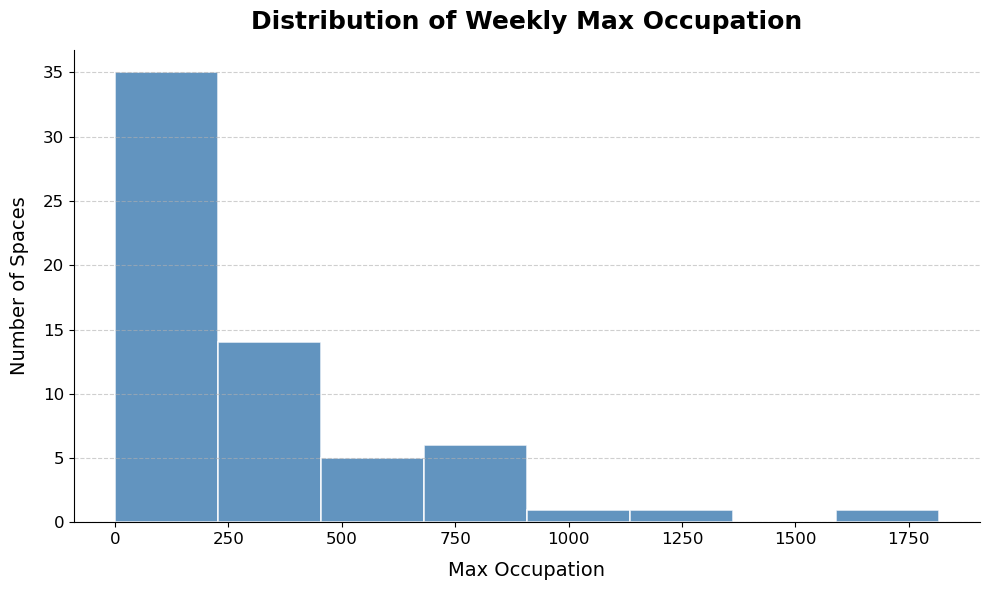

In [10]:
# Histogram of above data (Weekly Max occupation)
plt.figure(figsize=(10,6))
plt.hist(
    avg_occ_week, 
    bins=8, 
    color="steelblue", 
    edgecolor="white", 
    linewidth=1.2, 
    alpha=0.85
)

# Titles & labels
plt.title("Distribution of Weekly Max Occupation", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Max Occupation", fontsize=14, labelpad=10)
plt.ylabel("Number of Spaces", fontsize=14, labelpad=10)

# Grid (only on y-axis for readability)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Clean style: remove top/right spines
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

# Tight layout for dashboard embedding
plt.tight_layout()
plt.show()

In [11]:
# Empty Buildings
empty_buildings = max_occ_time[max_occ_time["avg_occ"] <= 5 ]
empty_buildings

building_name          space_name           date_time  avg_occ
20    Building_13  Space1_Building_13 2023-03-06 00:00:00        1
21    Building_13  Space1_Building_13 2023-03-07 09:00:00        5
22    Building_13  Space1_Building_13 2023-03-08 17:00:00        4
23    Building_13  Space1_Building_13 2023-03-09 00:00:00        2
24    Building_13  Space1_Building_13 2023-03-10 18:00:00        2
310    Building_9   Space2_Building_9 2023-03-06 00:00:00        0
311    Building_9   Space2_Building_9 2023-03-07 00:00:00        0
312    Building_9   Space2_Building_9 2023-03-08 00:00:00        0
313    Building_9   Space2_Building_9 2023-03-09 00:00:00        0
314    Building_9   Space2_Building_9 2023-03-10 00:00:00        0

Max Std: Space1_Building_38 index: 48


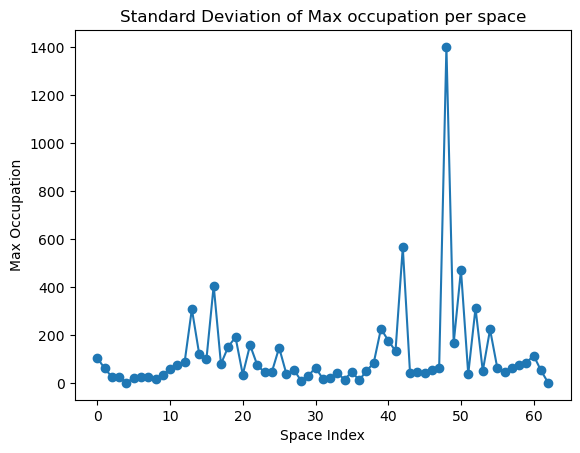

In [12]:
# Plotting Standard Deviation of ma ocucpation per space relative to
var = max_occ_time.groupby(["building_name","space_name"])["avg_occ"].std()
var = np.array(var).astype(int)
x = np.arange(var.size)
index = np.argmax(var)

# Finding Space with max std
max_std_space = max_occ_time["space_name"].unique()[index]
print("Max Std:",max_std_space,"index:",index)

plt.plot(x,var,"-o")
plt.title("Standard Deviation of Max occupation per space")
plt.xlabel("Space Index")
plt.ylabel("Max Occupation")
plt.show()

Most buildings vary the same, except a few outliers, probaly because they have bigger occupations to begin with. But the big spike should be investigated.

In [13]:
# Creating a Coeffecient of Variation
ratio = []
size = var.size
count = 0
for mean, std in zip (avg_occ_week,var):
    if mean >= 10:                        # Drop anything less than 10 occupation to avoid large instable flucations
        ratio.append(std/mean) 
        count = count + 1
print(size-count,"dropped.")

2 dropped.


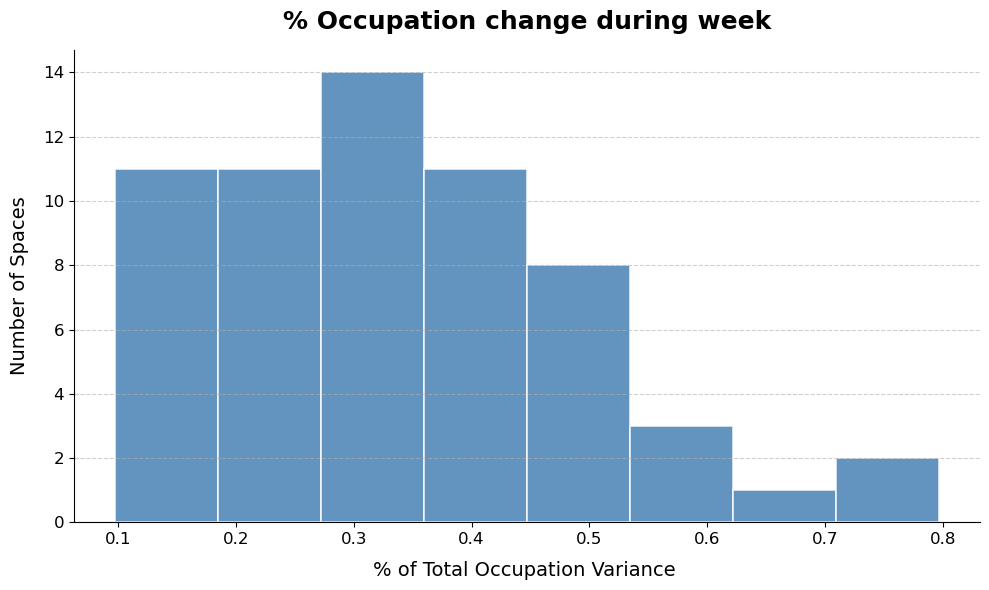

In [14]:
# histogram for variance
plt.figure(figsize=(10,6))
plt.hist(
    ratio, 
    bins=8, 
    color="steelblue", 
    edgecolor="white", 
    linewidth=1.2, 
    alpha=0.85
)

# Titles & labels
plt.title("% Occupation change during week", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("% of Total Occupation Variance ", fontsize=14, labelpad=10)
plt.ylabel("Number of Spaces", fontsize=14, labelpad=10)

# Grid (y-axis only)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove unnecessary spines
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

# Tight layout for neat embedding
plt.tight_layout()
plt.show()

In [15]:
# Looking at how building 38 decreases so much during the week

print(max_occ_time[(max_occ_time["space_name"] == max_std_space)].reset_index(drop=True))
print("Percent of start of work week:",int(100*(813/4010)),"%")

  building_name          space_name           date_time  avg_occ
0   Building_38  Space1_Building_38 2023-03-06 23:00:00     4010
1   Building_38  Space1_Building_38 2023-03-07 01:00:00     2425
2   Building_38  Space1_Building_38 2023-03-08 00:00:00     1093
3   Building_38  Space1_Building_38 2023-03-09 17:00:00      739
4   Building_38  Space1_Building_38 2023-03-10 23:00:00      813
Percent of start of work week: 20 %


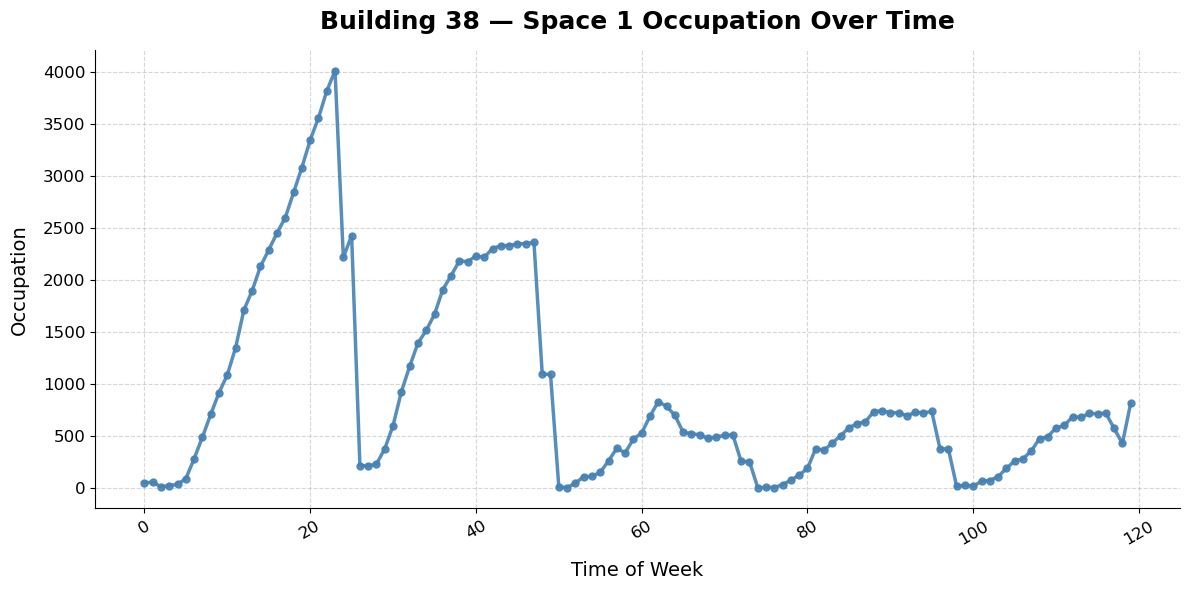

In [16]:
# Time series of Building 38 anamoly 

df_38 = df_occ[df_occ["space_name"]== max_std_space].reset_index(drop=True)
x = np.arange(df_38["avg_occ"].size)
y = (df_38["avg_occ"])
plt.figure(figsize=(12,6))

# Line plot with markers for clarity
plt.plot(x, y, color="steelblue", linewidth=2.5, marker="o", markersize=5, alpha=0.9)

# Titles & labels
plt.title("Building 38 — Space 1 Occupation Over Time", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Time of Week", fontsize=14, labelpad=10)
plt.ylabel("Occupation", fontsize=14, labelpad=10)

# Grid for readability
plt.grid(True, linestyle="--", alpha=0.5)

# Axis ticks
plt.xticks(fontsize=12, rotation=30)   # rotate if time labels overlap
plt.yticks(fontsize=12)

# Remove unnecessary spines for clean look
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

Building 38 substantially looses its occupation as week goes on. Monday and Tuesday most busy

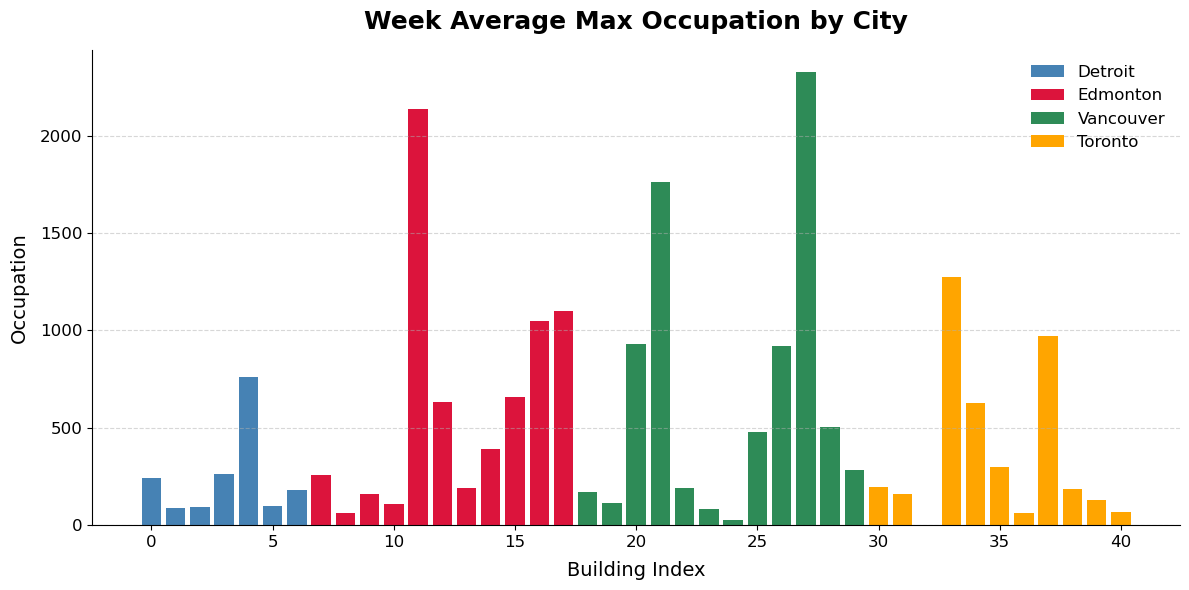

In [17]:
# Get average max occupation per day
max_occ_time = df_occ.loc[df_occ.groupby(["city","building_name","space_name","date_daily"])["avg_occ"].idxmax(), 
       ["city","building_name","date_time","space_name","avg_occ"]].reset_index(drop=True)

# Average per day
mean_occ_space =(     
    max_occ_time
    .groupby(["city", "building_name","space_name"])["avg_occ"]
    .mean()
    .reset_index()
)

# Sum across all spaces
city_building_occ =(     
    mean_occ_space
    .groupby(["city", "building_name"])["avg_occ"]
    .sum()
    .reset_index()
)

# Visualzing building occupation by city
detroit_occ = np.array(city_building_occ[(city_building_occ["city"] == "Detroit")].reset_index(drop=True)["avg_occ"].astype(int)) 
edmonton_occ = np.array(city_building_occ[(city_building_occ["city"] == "Edmonton")].reset_index(drop=True)["avg_occ"].astype(int))
vancouver_occ = np.array(city_building_occ[(city_building_occ["city"] == "Vancouver")].reset_index(drop=True)["avg_occ"].astype(int))
toronto_occ = np.array(city_building_occ[(city_building_occ["city"] == "Toronto")].reset_index(drop=True)["avg_occ"].astype(int)) 
# Concatenate all into one sequence
all_data = np.concatenate([detroit_occ, edmonton_occ, vancouver_occ, toronto_occ])
# Category boundaries
lengths = [len(detroit_occ), len(edmonton_occ), len(vancouver_occ), len(toronto_occ)]
labels  = ["Detroit", "Edmonton", "Vancouver", "Toronto"]
colors  = ["steelblue", "crimson", "seagreen", "orange"]

# Base x positions
x = np.arange(len(all_data))

plt.figure(figsize=(12,6))

# Plot each block with its color
start = 0
for length, label, color in zip(lengths, labels, colors):
    end = start + length
    plt.bar(x[start:end], all_data[start:end], color=color, label=label)
    start = end

# Titles & labels
plt.title("Week Average Max Occupation by City", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Building Index", fontsize=14, labelpad=8)
plt.ylabel("Occupation", fontsize=14, labelpad=8)

# Grid & style
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.show()

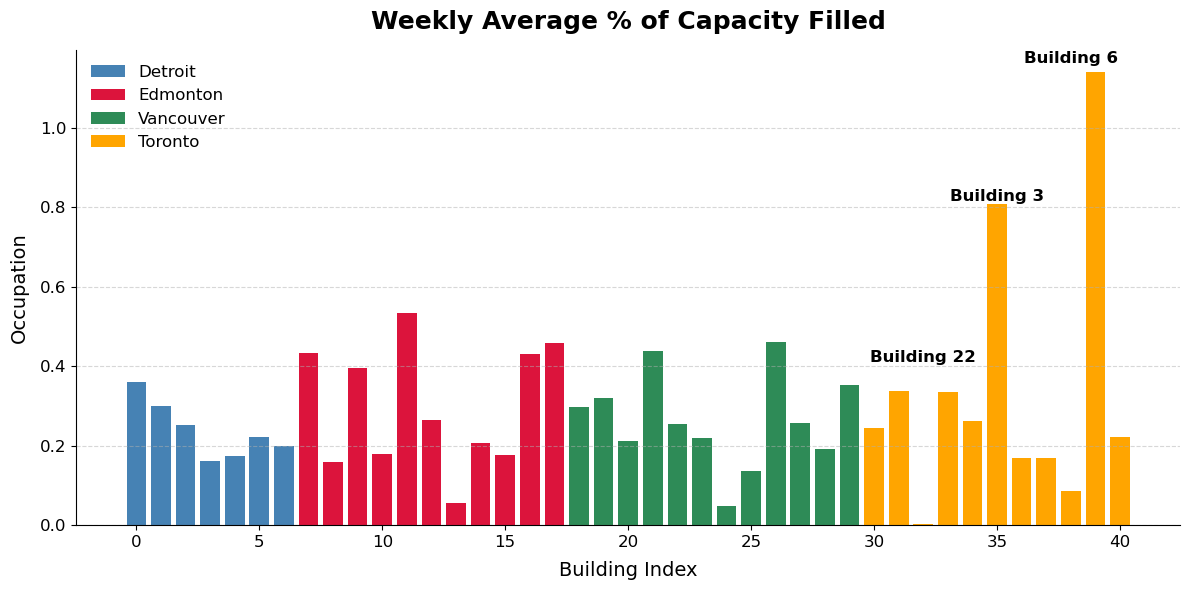

In [18]:
# Calculate capacity
max_occ_capacity = df_occ.loc[df_occ.groupby(["city","building_name","space_name"])["avg_occ"].idxmax(), 
       ["city","building_name","capacity","space_name","avg_occ"]].reset_index(drop=True)

df_capacity_building = (max_occ_capacity.groupby(["city", "building_name"])["capacity"].sum().reset_index())
building_names = df_capacity_building["building_name"]

detroit_cap = (df_capacity_building[df_capacity_building["city"] == "Detroit"])["capacity"]
edmonton_cap = (df_capacity_building[df_capacity_building["city"] == "Edmonton"])["capacity"]
vancouver_cap = (df_capacity_building[df_capacity_building["city"] == "Vancouver"])["capacity"]
toronto_cap = (df_capacity_building[df_capacity_building["city"] == "Toronto"])["capacity"]

# Get average max occupation per day
max_occ_time = df_occ.loc[df_occ.groupby(["city","building_name","space_name","date_daily"])["avg_occ"].idxmax(), 
       ["city","building_name","capacity","date_time","space_name","avg_occ"]].reset_index(drop=True)

# Average per day
mean_occ_space =(     
    max_occ_time
    .groupby(["city", "building_name","space_name"])["avg_occ"]
    .mean()
    .reset_index()
)

# Sum across all spaces
city_building_occ =(     
    mean_occ_space
    .groupby(["city", "building_name"])["avg_occ"]
    .sum()
    .reset_index()
)

# Occupation arrays
detroit_occ = np.array(city_building_occ[(city_building_occ["city"] == "Detroit")].reset_index(drop=True)["avg_occ"].astype(int)) 
edmonton_occ = np.array(city_building_occ[(city_building_occ["city"] == "Edmonton")].reset_index(drop=True)["avg_occ"].astype(int))
vancouver_occ = np.array(city_building_occ[(city_building_occ["city"] == "Vancouver")].reset_index(drop=True)["avg_occ"].astype(int))
toronto_occ = np.array(city_building_occ[(city_building_occ["city"] == "Toronto")].reset_index(drop=True)["avg_occ"].astype(int)) 

# Concatenate all into one sequence
all_data = np.concatenate([detroit_occ / detroit_cap, edmonton_occ / edmonton_cap, vancouver_occ / vancouver_cap , toronto_occ/ toronto_cap])
# Category boundaries
lengths = [len(detroit_occ), len(edmonton_occ), len(vancouver_occ), len(toronto_occ)]
labels  = ["Detroit", "Edmonton", "Vancouver", "Toronto"]
colors  = ["steelblue", "crimson", "seagreen", "orange"]

# Base x positions
x = np.arange(len(all_data))

plt.figure(figsize=(12,6))

# Plot each block with its color
start = 0
for length, label, color in zip(lengths, labels, colors):
    end = start + length
    plt.bar(x[start:end], all_data[start:end], color=color, label=label)
    start = end

# Titles & labels
plt.title("Weekly Average % of Capacity Filled", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Building Index", fontsize=14, labelpad=8)
plt.ylabel("Occupation", fontsize=14, labelpad=8)

# Grid & style
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
# Annotate Building 3 at index 35
plt.text(
    35, 
    all_data[35],         # slightly above the bar height
    "Building 3", 
    ha="center", va="bottom", fontsize=12, fontweight="bold"
)

# Annotate Building 6 at index 38
plt.text(
    38, 
    all_data[38]+1.07 , 
    "Building 6", 
    ha="center", va="bottom", fontsize=12, fontweight="bold"
)
# Low usage building
plt.text(
    32, 
    all_data[32]+.4 , 
    "Building 22", 
    ha="center", va="bottom", fontsize=12, fontweight="bold"
)
plt.show()

In [19]:
# Buildings below 20%
for i in range(all_data.size):
    if all_data[i] < .2:
        print(building_names[i],":",all_data[i])

Building_36 : 0.16119221411192214
Building_39 : 0.1751959428307976
Building_7 : 0.1988888888888889
Building_14 : 0.15789473684210525
Building_2 : 0.18
Building_30 : 0.054857142857142854
Building_40 : 0.17708612825328682
Building_28 : 0.048
Building_32 : 0.13714285714285715
Building_4 : 0.19062027231467474
Building_22 : 0.0022222222222222222
Building_31 : 0.17027027027027028
Building_34 : 0.16793103448275862
Building_38 : 0.08619091751621873


In [20]:
print("High capacity usage: ",building_names[35],"and",building_names[39])
print("Low usage:",building_names[32])

High capacity usage:  Building_3 and Building_6
Low usage: Building_22


In [21]:
# Buildings and spaces with most traffic
traffic = df_occ.groupby(["city","building_name", "space_name"])["traffic"].max()
traffic

city       building_name  space_name        
Detroit    Building_15    Space1_Building_15     504.0
           Building_17    Space1_Building_17      97.0
           Building_29    Space1_Building_29     199.0
           Building_36    Space1_Building_36    1280.0
                          Space2_Building_36     166.0
                                                 ...  
Vancouver  Building_38    Space2_Building_38    1092.0
           Building_6     Space1_Building_6      410.0
                          Space2_Building_6      433.0
           Building_9     Space1_Building_9      394.0
                          Space2_Building_9        0.0
Name: traffic, Length: 63, dtype: float64

In [22]:
# Time of Max people_in
time_of_entry = df_occ.loc[df_occ.groupby(["city","building_name","space_name"])["people_in"].idxmax(),
       ["city","building_name","date_time","people_in"]]
time_of_entry["entry_hour"] = np.array(time_of_entry["date_time"].dt.hour)
entry_times = np.array(time_of_entry["date_time"].dt.hour)
df_13 = time_of_entry[time_of_entry["entry_hour"] == 12].reset_index()
df_8 =  time_of_entry[time_of_entry["entry_hour"] == 8]
#time_of_entry["entry_hour"].to_excel("entry_times.xlsx",index=False)

In [23]:
# Time of Max people_out
time_of_exit = df_occ.loc[df_occ.groupby(["city","building_name","space_name"])["people_out"].idxmax(),
       ["city","building_name","date_time","people_out"]]
time_of_exit["exit_hour"] = np.array(time_of_exit["date_time"].dt.hour)
exit_times = np.array(time_of_exit["date_time"].dt.hour)
#time_of_exit["exit_hour"].to_excel("exit_times.xlsx",index=False)

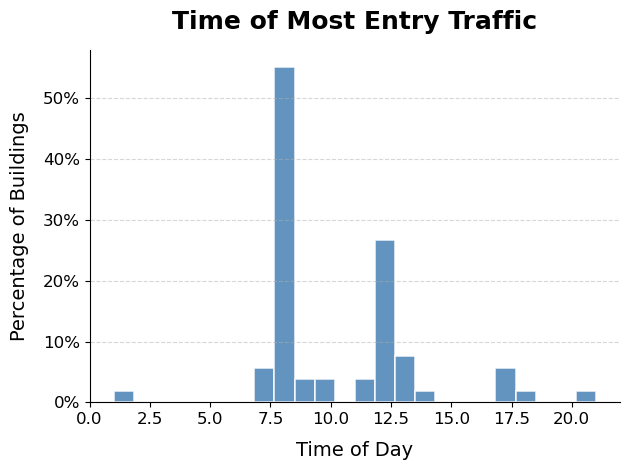

In [24]:
# Histogram normalized to percentages
plt.hist(
    entry_times,
    bins=24,
    density=True,
    color="steelblue",
    edgecolor="white",
    linewidth=1.2,
    alpha=0.85
)

# Format y-axis as %
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x*100:.0f}%")

# Titles and labels
plt.title("Time of Most Entry Traffic", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Time of Day", fontsize=14, labelpad=10)
plt.ylabel("Percentage of Buildings", fontsize=14, labelpad=10)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Clean style (remove cluttered spines)
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

Second peak might be due to people coming in from lunch plus late day workers

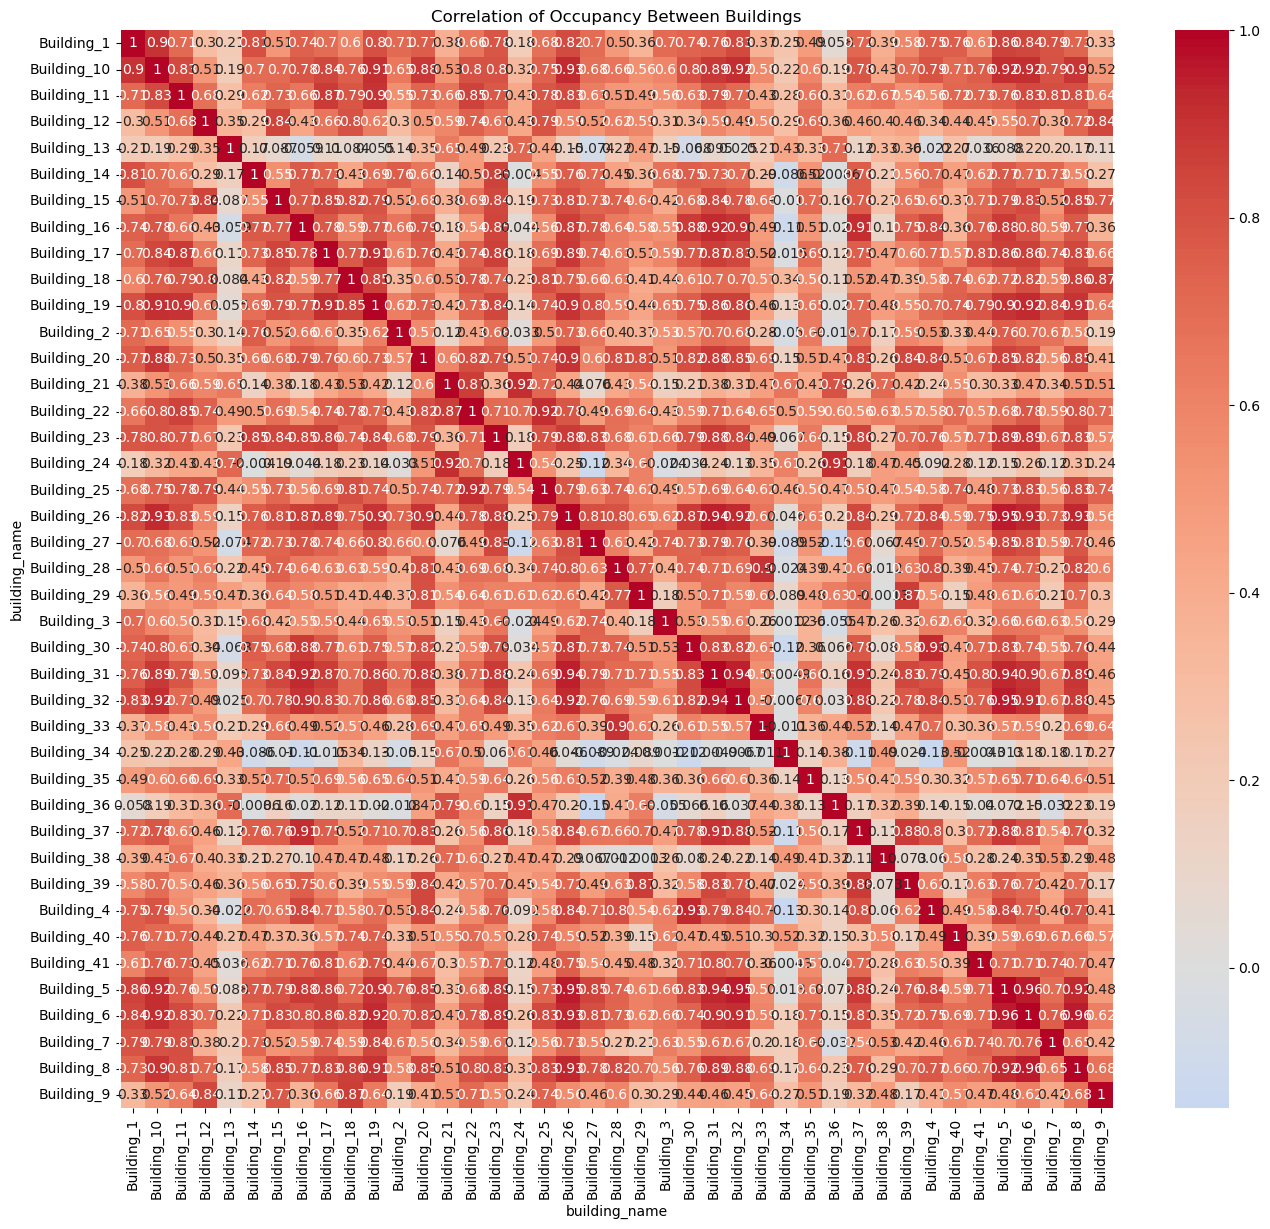

In [25]:
# Correlations

# Pivot so each building has its own column
df_wide = df_occ.pivot_table(
    index="date_time",
    columns="building_name",
    values="avg_occ"
)
corr_matrix = df_wide.corr()

plt.figure(figsize=(16,14))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation of Occupancy Between Buildings")
plt.show()


Most buildings appear correlated, but this is because of the work scheduel I believe... Building 34 shows a difference compared to rest.

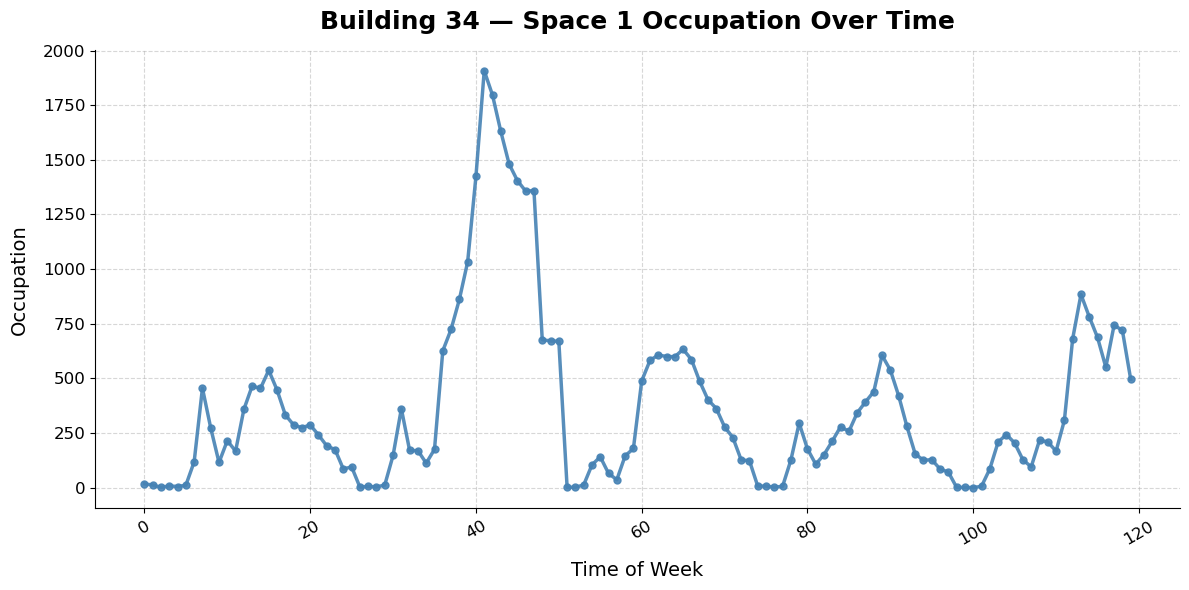

In [26]:
# Time series of Building 34

df_34 = df_occ[df_occ["space_name"]== "Space1_Building_34"].reset_index(drop=True)
x = np.arange(df_34["avg_occ"].size)
y = (df_34["avg_occ"])
plt.figure(figsize=(12,6))

# Line plot with markers for clarity
plt.plot(x, y, color="steelblue", linewidth=2.5, marker="o", markersize=5, alpha=0.9)

# Titles & labels
plt.title("Building 34 — Space 1 Occupation Over Time", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Time of Week", fontsize=14, labelpad=10)
plt.ylabel("Occupation", fontsize=14, labelpad=10)

# Grid for readability
plt.grid(True, linestyle="--", alpha=0.5)

# Axis ticks
plt.xticks(fontsize=12, rotation=30)   # rotate if time labels overlap
plt.yticks(fontsize=12)

# Remove unnecessary spines for clean look
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

Tuesday showed huge spike in occupation.